## 2 Layer MLP
- With hidden layer of size 64 and dropout with 0.5 probability
- Softmax at last classification layer 
- Learning rate of 0.001
- Over 50-100 epochs

In [21]:
import numpy as np
import tensorflow as tf
import argparse
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error
import math
# import wandb
# from wandb.integration.keras.callbacks import WandbMetricsLogger, WandbModelCheckpoint


encoder = load_model("../Models/Decoder/encoder_classifier.keras")
X = np.load("../Data/LPS/sal-lps-150-1500(labeled)_data.npy")
Y = np.load("../Data/LPS/sal-lps-150-1500(labeled)_labels.npy")
# X = np.load("../Data/LPS/sal-lps-150-1500(labeled)_fulltest_data.npy")
# Y = np.load("../Data/LPS/sal-lps-150-1500(labeled)_fulltest_labels.npy")
print(X.shape)


(3274, 67499)


In [22]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0015,
    decay_steps=500,
    decay_rate=0.96,
    staircase=True
)

In [23]:
# wandb.init(

#     project="Classifier Tuning",

#     # track hyperparameters and run metadata with wandb.config
#     config={
#         "hidden_size": 64,
#         "activation_1": "tanh",
#         "dropout": 0.5,
#         "output_size": 2,
#         "output_activation": "softmax",
#         "optimizer": "adam",
#         "learning_rate": lr_schedule,
#         "loss": "sparse_categorical_crossentropy",
#         "metric": "accuracy",
#         "epochs": 50,
#         "batch_size": 32
#     }
# )

# config = wandb.config

In [24]:
class MLPClassifier(tf.keras.Model):
    def __init__(self, encoder, num_classes=2, hidden_size=64, dropout_rate=0.5):
        super().__init__()
        self.encoder = encoder
        # freeze encoder if requested
        self.encoder.trainable = False
        self.hidden = layers.Dense(hidden_size, activation='tanh')
        self.dropout = layers.Dropout(dropout_rate)
        # classifier head as a keras.Sequential so it can be saved/attached elsewhere
        self.classifier = tf.keras.Sequential([
            layers.Dense(hidden_size, activation='tanh'),
            layers.Dropout(dropout_rate),
            layers.Dense(num_classes, activation='softmax')
        ])

    def call(self, inputs, training=True):
        x = self.encoder(inputs, training=training)   # pass through encoder
        # pass through classifier head
        return self.classifier(x, training=training)
     

In [25]:
# Split into train (60%), temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)
# Split temp into val (50% of temp = 20% total) and test (50% of temp = 20% total)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.67, random_state=42, stratify=y_temp)
del X, X_temp, y_temp

In [26]:
print(f'Training data shape: {X_train.shape}')
print(f'Val data shape: {X_val.shape}')
print(f'Test data shape: {X_test.shape}')


Training data shape: (2291, 67499)
Val data shape: (324, 67499)
Test data shape: (659, 67499)


In [27]:
# for layer in encoder.layers:
#     layer.trainable = True
model = MLPClassifier(encoder, hidden_size=64, dropout_rate=0.5)

early_stopping = EarlyStopping(
    monitor='accuracy',
    patience=4,
    restore_best_weights=True
)



model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
            )

print("Training started....")
history = model.fit(
    X_train, y_train,
    epochs=50, batch_size=32,    
    validation_data=(X_val, y_val), 
    verbose=1,
    callbacks=[early_stopping,
            #    WandbMetricsLogger(),
            #    WandbModelCheckpoint("models.keras",save_best_only=True,monitor='accuracy')
               ]
)
# wandb.finish()
print("Training completed!")


Training started....
Epoch 1/50


/home/vmuser/anaconda3/lib/python3.12/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'mlp_classifier_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.9812 - loss: 0.0468 - val_accuracy: 0.9969 - val_loss: 0.0142
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 1.0000 - loss: 2.3704e-05 - val_accuracy: 0.9969 - val_loss: 0.0142
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 1.0000 - loss: 2.2621e-05 - val_accuracy: 0.9969 - val_loss: 0.0142
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 1.0000 - loss: 2.5226e-05 - val_accuracy: 0.9969 - val_loss: 0.0142
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 1.0000 - loss: 2.2580e-05 - val_accuracy: 0.9969 - val_loss: 0.0143
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 1.0000 - loss: 2.0488e-05 - val_accuracy: 0.9969 - val_loss: 0.0143
Training completed!


In [28]:
model.summary()

Model: "mlp_classifier_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 250)            │   137,251,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 2)              │        16,194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,299,833 (523.76 MB)

 Trainable params: 16,194 (63.26 KB)

 Non-trainable params: 137,251,250 (523.57 MB)

 Optimizer params: 32,389 (126.52 KB)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9970 - loss: 0.0188
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
TN: 328, FP: 1, FN: 1, TP: 329
AUC: 0.9999723680574745


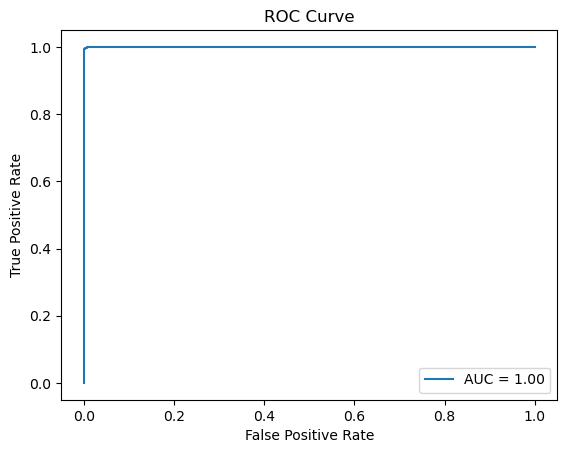

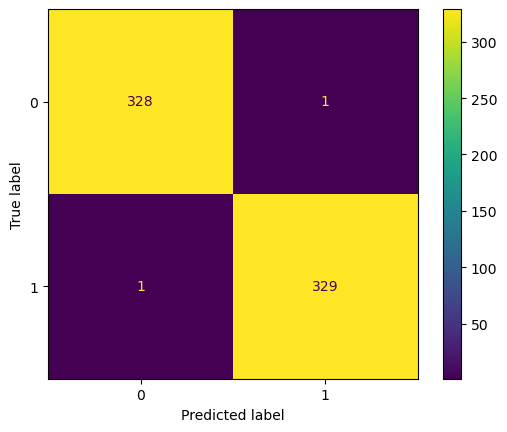

Test loss: 0.0187514778226614
Test Accuracy 0.9969651103019714
Precision: 0.9970
Recall (Sensitivity/TPR): 0.9970
Specificity (TNR): 0.9970
F1-Score: 0.9970
False Positive Rate (FPR): 0.0030
False Negative Rate (FNR): 0.0030
Negative Predictive Value (NPV): 0.9970


In [29]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay,precision_score,recall_score,f1_score

loss, accuracy = model.evaluate(X_test, y_test)

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)


cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print(f'TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}')

if len(np.unique(y_test)) == 2:
    auc = roc_auc_score(y_test, y_pred_probs[:, 1])
    print(f'AUC: {auc}')
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs[:, 1])
    import matplotlib.pyplot as plt
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Confusion matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print(f'Test loss: {loss}')
print(f'Test Accuracy {accuracy}')
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
specificity = tn / (tn + fp)
false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (fn + tp)
true_positive_rate = tp / (tp + fn)  # Same as recall/sensitivity
negative_predictive_value = tn / (tn + fn)

print(f'Precision: {precision:.4f}')
print(f'Recall (Sensitivity/TPR): {recall:.4f}')
print(f'Specificity (TNR): {specificity:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'False Positive Rate (FPR): {false_positive_rate:.4f}')
print(f'False Negative Rate (FNR): {false_negative_rate:.4f}')
print(f'Negative Predictive Value (NPV): {negative_predictive_value:.4f}')

In [31]:
# model.encoder.save("../Models/Decoder/encoder_classifier.keras")
model.classifier.save("../Models/Decoder/classifier.keras")
